# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


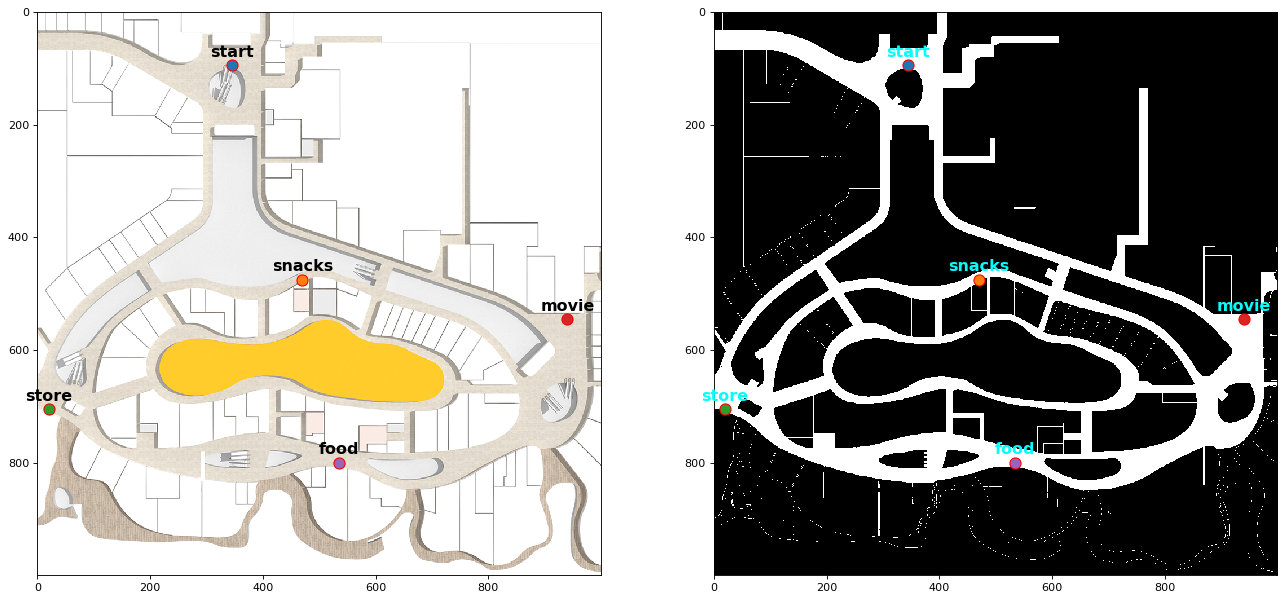

In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map = imageio.imread('./map/vivocity_freespace.png')
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start': [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],  # Garrett Popcorn
             'store': [20, 705],    # DJI Store
             'movie': [940, 545],   # Golden Village
             'food': [535, 800],    # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Task 1

In [20]:
import math
import heapq
import datetime

class Env:
    def __init__(self, grid_map, map_res):
        self.x_range = grid_map.shape[0]  # size of background
        self.y_range = grid_map.shape[1]
        self.motions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)]     # 8 neighbor, 8 motions
        self.map_res = map_res  # map resolution
        self.obs = self.obs_map(grid_map)    # construct the obstacles
    

    """
        Initialize obstacles' positions
        :return: map of obstacles
    """
    def obs_map(self, grid_map):

        obs = set()     # set for fast research

        # Find obstacles (==0, include boundary)
        obs_array = np.argwhere(grid_map==0)

        for t in obs_array:
            obs.add((t[0], t[1]))     
        
        return obs

    """
        AStar: f(n) = g(n) + h(n), where h(n) = 0 for Dijkstra's
    """
class AStar:
    def __init__(self, s_start, s_end, heuristic_function, env, footprint_radius):
        self.s_start = s_start  # start point
        self.s_end = s_end      # end point
        self.heuristic_function = heuristic_function    # type of heuristic function

        self.env = env  # the environment

        self.u_set = self.env.motions               # expand directions (inputs)
        self.obs = self.env.obs                     # the obstacles
        self.map_res = self.env.map_res             # map resolution
        self.footprint_radius = footprint_radius    # the radius of a circular footprint

        self.openset = []               # a priority queue
        self.closeset = []              # closeset for node expanded
        self.parent_node = dict()       # link nodes and its parent
        self.g = dict()                 # cost g(n)
        self.total_distance = 0         # total distance of the optimal path
        
        
    # Different kinds of heuristic type design
    def heuristic(self, s):
        # h(n)
        heuristic_function = self.heuristic_function
        end = self.s_end
        
        # Dijkstra's
        if heuristic_function == "Dijkstra's":
            return 0
        # Manhattan metrics
        elif heuristic_function == "manhattan":
            return abs(end[0] - s[0]) + abs(end[1] - s[1])
        # Diagonal metrics
        elif heuristic_function == "diagonal":
            p = 0.0001
            h = abs(end[0] - s[0]) + abs(end[1] - s[1]) + (math.sqrt(2) - 2) * min(abs(end[0] - s[0]), abs(end[1] - s[1]))
            h = h * (1 + p)
            return h
        # Euclidean metrics
        else:
            return math.hypot(end[0] - s[0], end[1] - s[1])


    # f(n) = g(n) + h(n), where h(n) = 0 for Dijkstra's
    def f_value(self, s):
        return self.g[s] + self.heuristic(s)


    # Get the edgecost between two nodes
    def edgecost(self, s_start, s_end):
        # Cost is inf if there's a obstacle along the way
        if self.is_collision(s_start, s_end):
            return math.inf
        # Otherwise, return the Euclidean distance
        return math.hypot(s_end[0] - s_start[0], s_end[1] - s_start[1])


    # pos -> index
    def pos2ind(self, pos):
        ind_x = math.floor(pos[0] / self.map_res)
        ind_y = math.floor(pos[1] / self.map_res)
        return [ind_x, ind_y]
    
    # index -> pos
    def ind2pos(self, ind):
        pos_x = (ind[0] + 0.5) * self.map_res
        pos_y = (ind[1] + 0.5) * self.map_res
        return [pos_x, pos_y]


    # Collision checking
    def is_collision(self, s_start, s_end):
        
        # ind -> pos
        s_start_pos = self.ind2pos(s_start)
        s_end_pos = self.ind2pos(s_end)
        
        # The neighbor need to be checked according to the footprint radius
        delta = math.floor((self.footprint_radius / math.sqrt(2)) / self.map_res)

        # If the start or end point is not reachable
        for idx in range(max(s_start[0] - delta, 0), min(s_start[0] + delta + 1, self.env.x_range)):
            for idy in range(max(s_start[1] - delta, 0), min(s_start[1] + delta + 1, self.env.y_range)):
                if (idx, idy) in self.obs:
                    return True

        for idx in range(max(s_end[0] - delta, 0), min(s_end[0] + delta + 1, self.env.x_range)):
            for idy in range(max(s_end[1] - delta, 0), min(s_end[1] + delta + 1, self.env.y_range)):
                if (idx, idy) in self.obs:
                    return True

        # If the footprint radius is very small (delta = 0), we also need to check if it moves diagonally
        if delta == 0:
            if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
                if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                    s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                    s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                else:
                    s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                    s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                if s1 in self.obs or s2 in self.obs:
                    return True
        
        return False

    # Get the neighbors of the current node
    def get_neighbor(self, s):
        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set]
    

    # Get the path from the s_end to s_start
    def get_path(self, parent_node):
        # initially, the s_end
        path = [self.s_end]
        s = self.s_end

        while True:
            # Get the parrent node of s and put it into path
            s = parent_node[s]
            path.append(s)
            # Find the s_start, break
            if s == self.s_start:
                break
        return list(path)
    
    
    # The whole workflow
    """
        Output: 
            • Your planned path 
            • The total travelled distance in meters 
            • All the cells visited by your algorithm 
            • The total run time of your algorithm 
            • Other critical performance indicators 
    """
    def searching(self):
        # Record time
        start_time = datetime.datetime.now()
        
        self.parent_node[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_end] = math.inf
        heapq.heappush(self.openset, (self.f_value(self.s_start), self.s_start))

        # If the openset is not empty
        while self.openset:
            # Take a node from openset to closeset
            _, s = heapq.heappop(self.openset)
            self.closeset.append(s)
            
            if s == self.s_end:  # find the path!
                break

            # Get neighbor ndoes (s_n) of s
            for s_n in self.get_neighbor(s):
                new_g = self.g[s] + self.edgecost(s, s_n)
                # Initialize g value of unexpanded nodes to be inf
                if s_n not in self.g:
                    self.g[s_n] = math.inf

                # g(s) + edgecost(s, s_n) < g(s_n), update dict g, rechoose parent
                if new_g < self.g[s_n]:
                    self.parent_node[s_n] = s
                    self.g[s_n] = new_g
                    heapq.heappush(self.openset, (self.f_value(s_n), s_n))

        # Your planned path
        planned_path = self.get_path(self.parent_node)

        # The total travelled distance in meters 
        total_distance = self.g[self.s_end] * 0.2

        # All the cells visited by your algorithm 
        visited_cells = self.closeset

        # The total run time of your algorithm 
        stop_time = datetime.datetime.now()
        time_cost = (stop_time - start_time).microseconds / 1000     # microseconds

        return planned_path, total_distance, visited_cells, time_cost
    

    # A helper function to plot the planned path on the map
    def plot_path(self, planned_path, color):
        for point in planned_path:
            plt.plot(point[1], point[0], marker="o", markersize=1, markeredgecolor=color)
        return 
        

------------------------Start!------------------------
From start to snacks
The total length of the path is: 142.4856997824495 m!
The total number of visited cells is: 62604 !
The total runtime for the algorithm is: 37.134 ms!
------------------------Start!------------------------
From start to store
The total length of the path is: 155.13321779309692 m!
The total number of visited cells is: 48950 !
The total runtime for the algorithm is: 659.476 ms!
------------------------Start!------------------------
From start to movie
The total length of the path is: 178.89057710597754 m!
The total number of visited cells is: 49582 !
The total runtime for the algorithm is: 705.184 ms!
------------------------Start!------------------------
From start to food
The total length of the path is: 223.32388155425184 m!
The total number of visited cells is: 144731 !
The total runtime for the algorithm is: 327.656 ms!


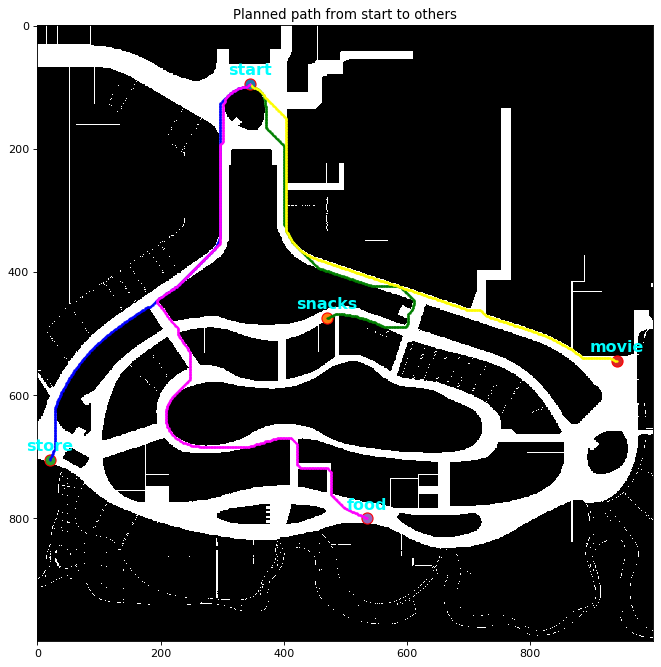

------------------------Start!------------------------
From snacks to start
The total length of the path is: 142.4856997824496 m!
The total number of visited cells is: 36173 !
The total runtime for the algorithm is: 223.919 ms!
------------------------Start!------------------------
From snacks to store
The total length of the path is: 114.79453095790642 m!
The total number of visited cells is: 25162 !
The total runtime for the algorithm is: 838.553 ms!
------------------------Start!------------------------
From snacks to movie
The total length of the path is: 107.50924958366775 m!
The total number of visited cells is: 13943 !
The total runtime for the algorithm is: 573.068 ms!
------------------------Start!------------------------
From snacks to food
The total length of the path is: 133.42884553295718 m!
The total number of visited cells is: 43622 !
The total runtime for the algorithm is: 990.339 ms!


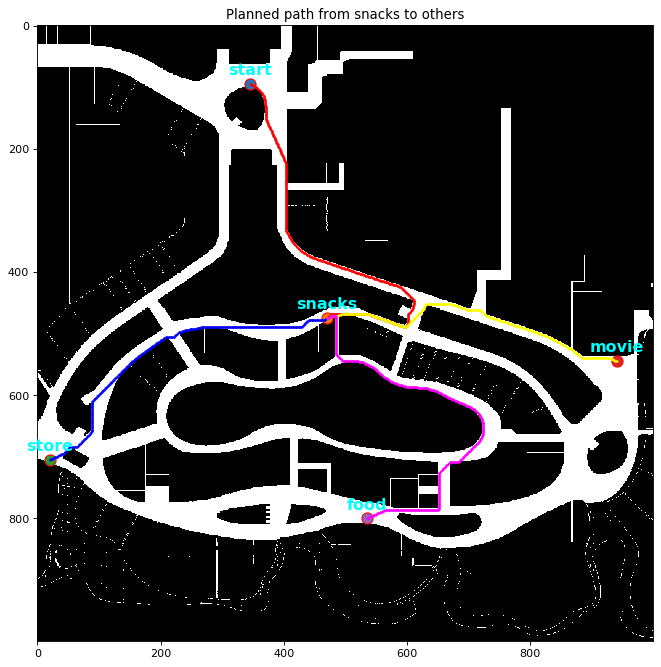

------------------------Start!------------------------
From store to start
The total length of the path is: 155.13321779309695 m!
The total number of visited cells is: 57344 !
The total runtime for the algorithm is: 43.066 ms!
------------------------Start!------------------------
From store to snacks
The total length of the path is: 114.79453095790628 m!
The total number of visited cells is: 38675 !
The total runtime for the algorithm is: 501.919 ms!
------------------------Start!------------------------
From store to movie
The total length of the path is: 209.41707063234804 m!
The total number of visited cells is: 89265 !
The total runtime for the algorithm is: 311.752 ms!
------------------------Start!------------------------
From store to food
The total length of the path is: 110.87005768508882 m!
The total number of visited cells is: 18468 !
The total runtime for the algorithm is: 179.106 ms!


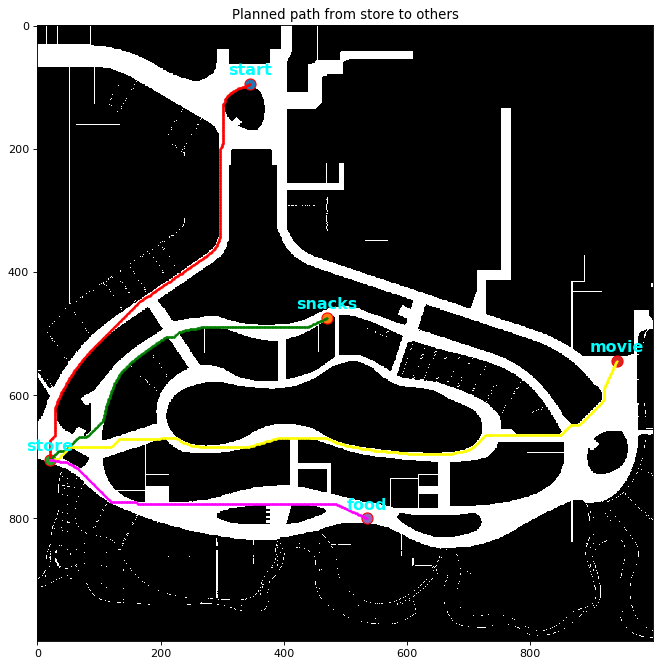

------------------------Start!------------------------
From movie to start
The total length of the path is: 178.89057710597757 m!
The total number of visited cells is: 42199 !
The total runtime for the algorithm is: 876.078 ms!
------------------------Start!------------------------
From movie to snacks
The total length of the path is: 107.50924958366771 m!
The total number of visited cells is: 14406 !
The total runtime for the algorithm is: 620.261 ms!
------------------------Start!------------------------
From movie to store
The total length of the path is: 209.41707063234796 m!
The total number of visited cells is: 52701 !
The total runtime for the algorithm is: 72.996 ms!
------------------------Start!------------------------
From movie to food
The total length of the path is: 113.72346314604074 m!
The total number of visited cells is: 43275 !
The total runtime for the algorithm is: 258.426 ms!


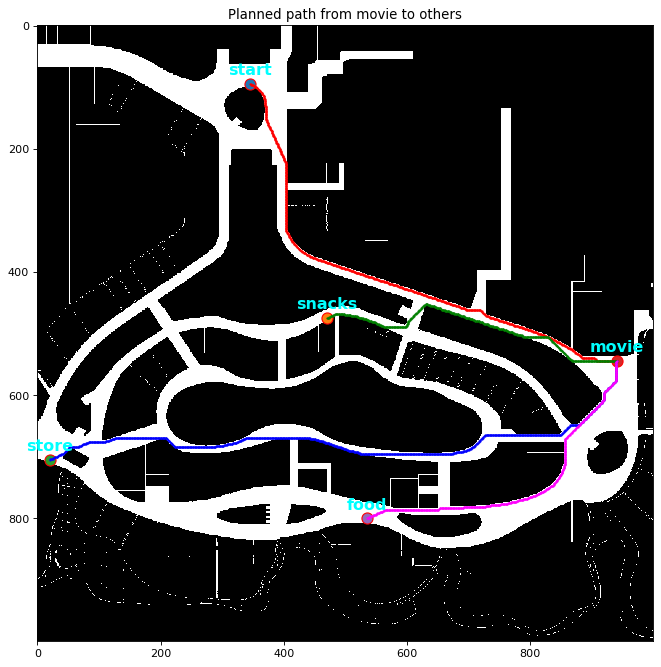

------------------------Start!------------------------
From food to start
The total length of the path is: 223.32388155425178 m!
The total number of visited cells is: 106386 !
The total runtime for the algorithm is: 25.838 ms!
------------------------Start!------------------------
From food to snacks
The total length of the path is: 133.42884553295715 m!
The total number of visited cells is: 56255 !
The total runtime for the algorithm is: 204.914 ms!
------------------------Start!------------------------
From food to store
The total length of the path is: 110.87005768508897 m!
The total number of visited cells is: 28002 !
The total runtime for the algorithm is: 265.265 ms!
------------------------Start!------------------------
From food to movie
The total length of the path is: 113.72346314604088 m!
The total number of visited cells is: 43050 !
The total runtime for the algorithm is: 875.81 ms!


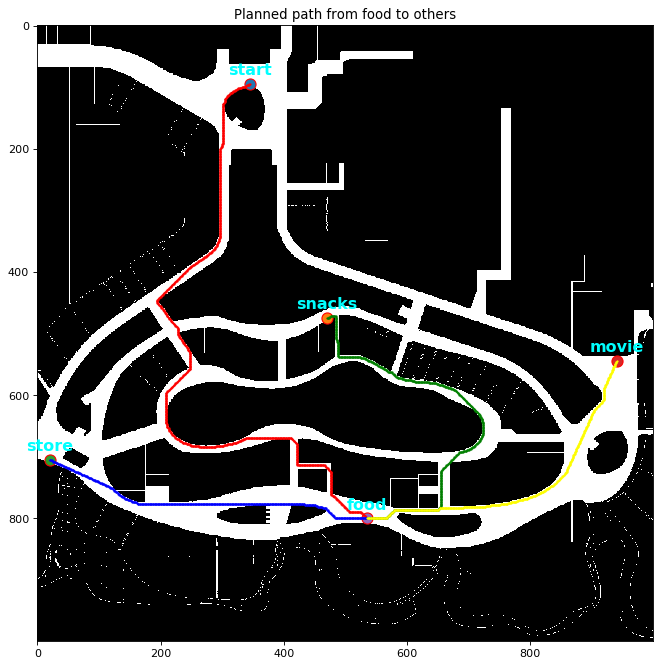

In [14]:
##  Implement A* planning algorithm on the map of the Vivocity level 2 
#   Create the env, map resolution is 0.2
env = Env(grid_map, 0.2) 

#   Different color to represent path between two points
color_dict = {'start': "red",    # Start from the level 2 Escalator
             'snacks': "green",  # Garrett Popcorn
             'store': "blue",    # DJI Store
             'movie': "yellow",    # Golden Village
             'food': "magenta",   # PUTIEN
            }

for key1, value1 in locations.items():

    # Plot and print the result
    plt.figure(figsize=(20, 10), dpi=80)
    # plt.subplot(1,2,1)
    plt.imshow(grid_map, cmap='gray')
    plot_locations(locations, color='cyan')

    for key2, value2 in locations.items():
        if key1 != key2:
            start_point = (locations[key1][1], locations[key1][0])
            end_point = (locations[key2][1], locations[key2][0])
            # footprint radius is 0.3
            astar = AStar(start_point, end_point, "euclidean", env, 0.3)
            planned_path, total_distance, visited_cells, time_cost = astar.searching()

            print("------------------------Start!------------------------")
            print("From {} to {}".format(key1, key2))

            # Plot the planned path
            astar.plot_path(planned_path, color_dict[key2])

            # Print the path length (m)
            print("The total length of the path is: {} m!".format(total_distance))
            
            # # Plot all the visited cells 
            # plt.subplot(1,2,2)
            # plt.imshow(grid_map, cmap='gray')
            # plot_locations(locations, color='cyan')
            # astar.plot_path(visited_cells)
            print("The total number of visited cells is: {} !".format(len(visited_cells)))

            # Print the total runtime of algorithm
            print("The total runtime for the algorithm is: {} ms!".format(time_cost))

    plt.title("Planned path from {} to others".format(key1))
    plt.show()



------------------------Start!------------------------
From start to snacks
The total length of the path is: 142.4856997824495 m!
The total number of visited cells is: 74603 !
The total runtime for the algorithm is: 620.631 ms!
------------------------Start!------------------------
From start to store
The total length of the path is: 155.13321779309692 m!
The total number of visited cells is: 3304 !
The total runtime for the algorithm is: 367.566 ms!
------------------------Start!------------------------
From start to movie
The total length of the path is: 178.89057710597754 m!
The total number of visited cells is: 2801 !
The total runtime for the algorithm is: 63.906 ms!
------------------------Start!------------------------
From start to food
The total length of the path is: 223.32388155425184 m!
The total number of visited cells is: 128348 !
The total runtime for the algorithm is: 669.03 ms!


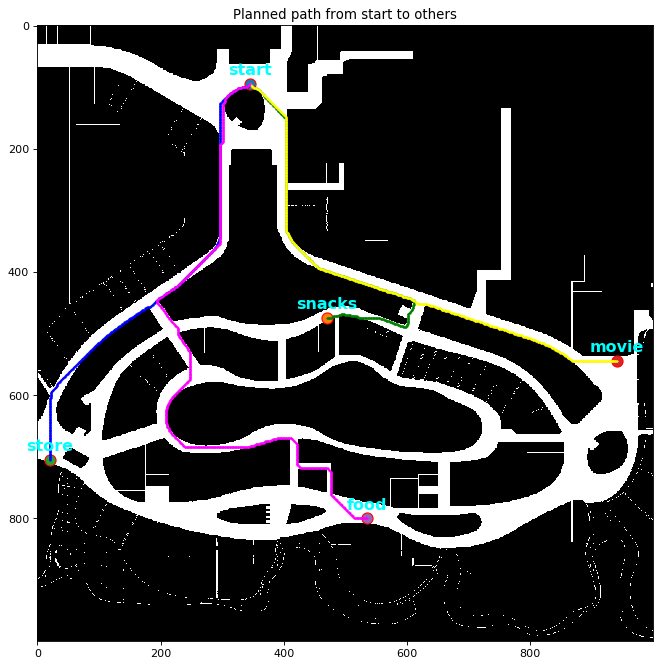

------------------------Start!------------------------
From snacks to start
The total length of the path is: 142.4856997824496 m!
The total number of visited cells is: 24153 !
The total runtime for the algorithm is: 760.426 ms!
------------------------Start!------------------------
From snacks to store
The total length of the path is: 118.59209229614233 m!
The total number of visited cells is: 4102 !
The total runtime for the algorithm is: 462.908 ms!
------------------------Start!------------------------
From snacks to movie
The total length of the path is: 107.50924958366775 m!
The total number of visited cells is: 15796 !
The total runtime for the algorithm is: 716.631 ms!
------------------------Start!------------------------
From snacks to food
The total length of the path is: 133.42884553295718 m!
The total number of visited cells is: 30181 !
The total runtime for the algorithm is: 916.779 ms!


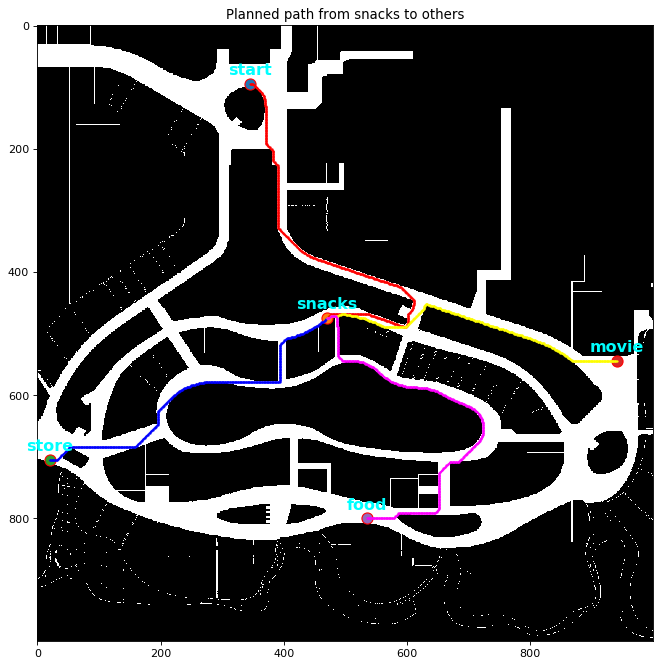

------------------------Start!------------------------
From store to start
The total length of the path is: 156.72144289248774 m!
The total number of visited cells is: 12999 !
The total runtime for the algorithm is: 696.554 ms!
------------------------Start!------------------------
From store to snacks
The total length of the path is: 114.79453095790628 m!
The total number of visited cells is: 3139 !
The total runtime for the algorithm is: 336.849 ms!
------------------------Start!------------------------
From store to movie
The total length of the path is: 209.41707063234804 m!
The total number of visited cells is: 92095 !
The total runtime for the algorithm is: 255.022 ms!
------------------------Start!------------------------
From store to food
The total length of the path is: 110.87005768508885 m!
The total number of visited cells is: 13057 !
The total runtime for the algorithm is: 125.943 ms!


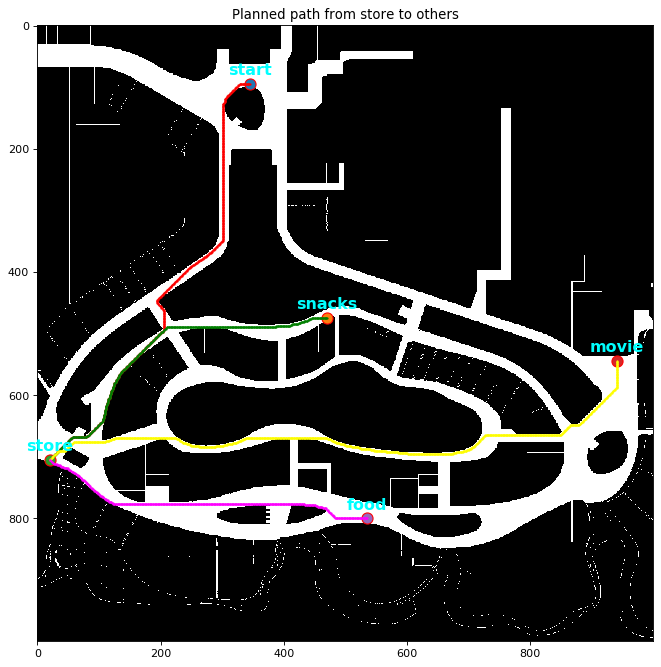

------------------------Start!------------------------
From movie to start
The total length of the path is: 178.89057710597757 m!
The total number of visited cells is: 2625 !
The total runtime for the algorithm is: 230.694 ms!
------------------------Start!------------------------
From movie to snacks
The total length of the path is: 107.50924958366771 m!
The total number of visited cells is: 15466 !
The total runtime for the algorithm is: 363.353 ms!
------------------------Start!------------------------
From movie to store
The total length of the path is: 209.41707063234796 m!
The total number of visited cells is: 34135 !
The total runtime for the algorithm is: 947.465 ms!
------------------------Start!------------------------
From movie to food
The total length of the path is: 114.0749350086169 m!
The total number of visited cells is: 2279 !
The total runtime for the algorithm is: 200.643 ms!


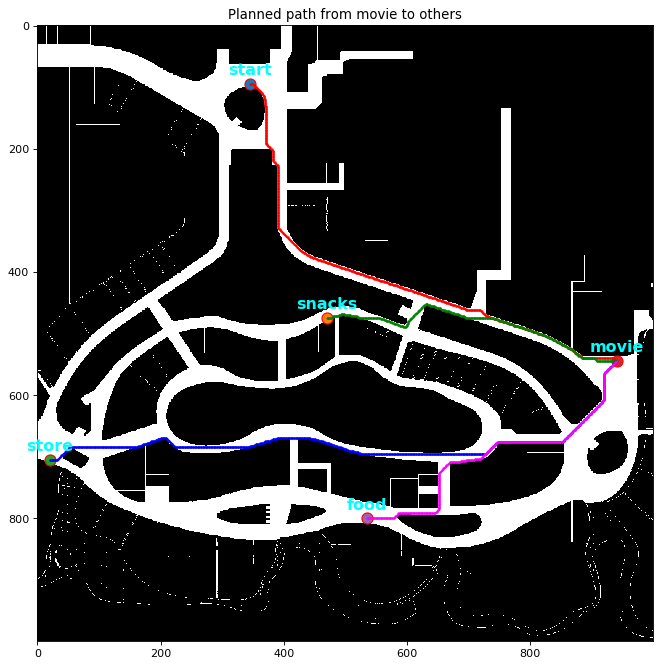

------------------------Start!------------------------
From food to start
The total length of the path is: 223.32388155425178 m!
The total number of visited cells is: 108166 !
The total runtime for the algorithm is: 354.67 ms!
------------------------Start!------------------------
From food to snacks
The total length of the path is: 133.42884553295715 m!
The total number of visited cells is: 52745 !
The total runtime for the algorithm is: 739.183 ms!
------------------------Start!------------------------
From food to store
The total length of the path is: 110.87005768508898 m!
The total number of visited cells is: 14278 !
The total runtime for the algorithm is: 273.583 ms!
------------------------Start!------------------------
From food to movie
The total length of the path is: 114.07493500861702 m!
The total number of visited cells is: 2889 !
The total runtime for the algorithm is: 314.84 ms!


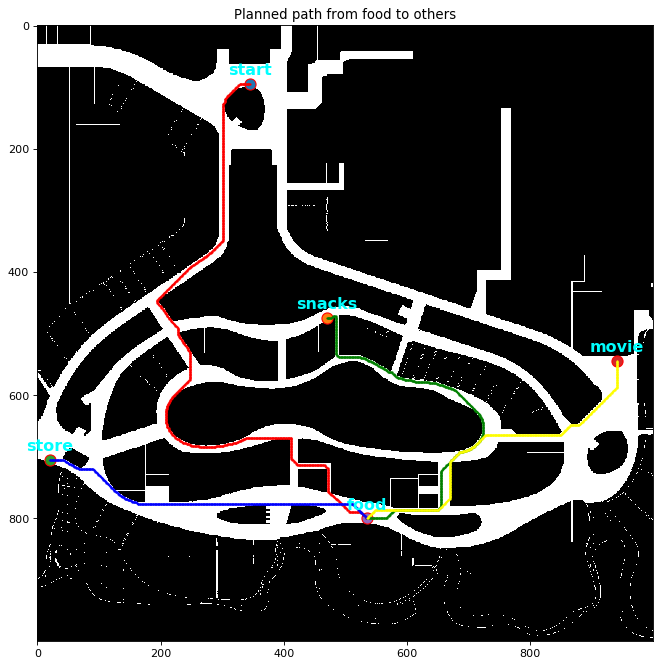

In [7]:
# Using Manhattan heuristic type

for key1, value1 in locations.items():

    # Plot and print the result
    plt.figure(figsize=(20, 10), dpi=80)
    # plt.subplot(1,2,1)
    plt.imshow(grid_map, cmap='gray')
    plot_locations(locations, color='cyan')

    for key2, value2 in locations.items():
        if key1 != key2:
            start_point = (locations[key1][1], locations[key1][0])
            end_point = (locations[key2][1], locations[key2][0])
            # footprint radius is 0.3
            astar = AStar(start_point, end_point, "manhattan", env, 0.3)
            planned_path, total_distance, visited_cells, time_cost = astar.searching()

            print("------------------------Start!------------------------")
            print("From {} to {}".format(key1, key2))

            # Plot the planned path
            astar.plot_path(planned_path, color_dict[key2])

            # Print the path length (m)
            print("The total length of the path is: {} m!".format(total_distance))

            print("The total number of visited cells is: {} !".format(len(visited_cells)))

            # Print the total runtime of algorithm
            print("The total runtime for the algorithm is: {} ms!".format(time_cost))

    plt.title("Planned path from {} to others".format(key1))
    plt.show()

------------------------Start!------------------------
From start to snacks
The total length of the path is: 142.4856997824495 m!
The total number of visited cells is: 725364 !
The total runtime for the algorithm is: 491.473 ms!
------------------------Start!------------------------
From start to store
The total length of the path is: 155.13321779309692 m!
The total number of visited cells is: 908754 !
The total runtime for the algorithm is: 355.77 ms!
------------------------Start!------------------------
From start to movie
The total length of the path is: 178.89057710597754 m!
The total number of visited cells is: 1309916 !
The total runtime for the algorithm is: 508.187 ms!
------------------------Start!------------------------
From start to food
The total length of the path is: 223.32388155425184 m!
The total number of visited cells is: 2322154 !
The total runtime for the algorithm is: 426.177 ms!


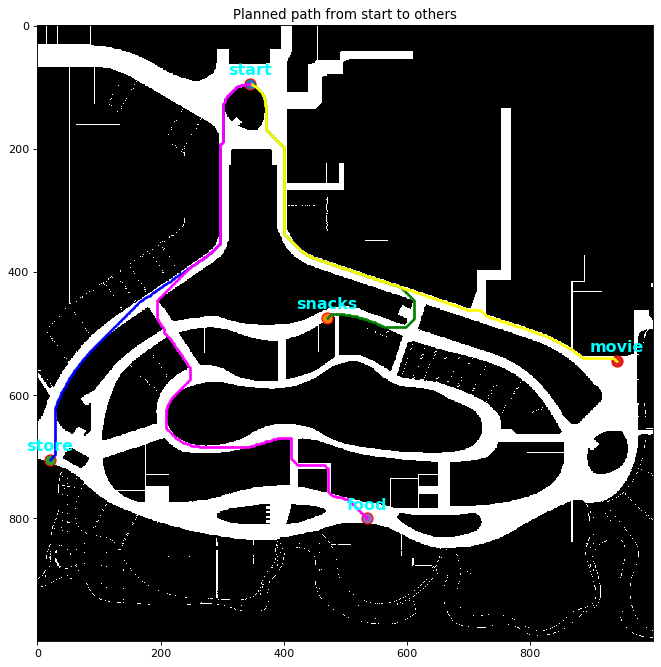

In [9]:
# Test Dijkstra's algorithm

key1 = 'start'

# Plot and print the result
plt.figure(figsize=(20, 10), dpi=80)
# plt.subplot(1,2,1)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')

for key2, value2 in locations.items():
    if key1 != key2:
        start_point = (locations[key1][1], locations[key1][0])
        end_point = (locations[key2][1], locations[key2][0])
        # footprint radius is 0.3
        astar = AStar(start_point, end_point, "Dijkstra's", env, 0.3)
        planned_path, total_distance, visited_cells, time_cost = astar.searching()

        print("------------------------Start!------------------------")
        print("From {} to {}".format(key1, key2))

        # Plot the planned path
        astar.plot_path(planned_path, color_dict[key2])

        # Print the path length (m)
        print("The total length of the path is: {} m!".format(total_distance))

        print("The total number of visited cells is: {} !".format(len(visited_cells)))

        # Print the total runtime of algorithm
        print("The total runtime for the algorithm is: {} ms!".format(time_cost))

plt.title("Planned path from {} to others".format(key1))
plt.show()

------------------------Start!------------------------
From start to snacks
The total length of the path is: 142.4856997824495 m!
The total number of visited cells is: 76363 !
The total runtime for the algorithm is: 185.549 ms!
------------------------Start!------------------------
From start to store
The total length of the path is: 155.13321779309692 m!
The total number of visited cells is: 35310 !
The total runtime for the algorithm is: 31.322 ms!
------------------------Start!------------------------
From start to movie
The total length of the path is: 178.89057710597754 m!
The total number of visited cells is: 47580 !
The total runtime for the algorithm is: 292.285 ms!
------------------------Start!------------------------
From start to food
The total length of the path is: 223.32388155425184 m!
The total number of visited cells is: 154767 !
The total runtime for the algorithm is: 483.445 ms!


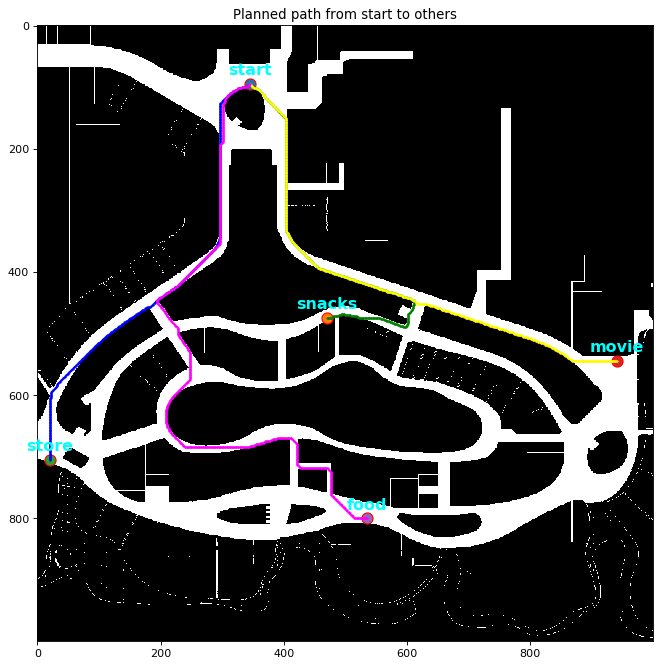

In [21]:
# Test improved algorithm

key1 = 'start'

# Plot and print the result
plt.figure(figsize=(20, 10), dpi=80)
# plt.subplot(1,2,1)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')

for key2, value2 in locations.items():
    if key1 != key2:
        start_point = (locations[key1][1], locations[key1][0])
        end_point = (locations[key2][1], locations[key2][0])
        # footprint radius is 0.3
        astar = AStar(start_point, end_point, "diagonal", env, 0.3)
        planned_path, total_distance, visited_cells, time_cost = astar.searching()

        print("------------------------Start!------------------------")
        print("From {} to {}".format(key1, key2))

        # Plot the planned path
        astar.plot_path(planned_path, color_dict[key2])

        # Print the path length (m)
        print("The total length of the path is: {} m!".format(total_distance))

        print("The total number of visited cells is: {} !".format(len(visited_cells)))

        # Print the total runtime of algorithm
        print("The total runtime for the algorithm is: {} ms!".format(time_cost))

plt.title("Planned path from {} to others".format(key1))
plt.show()

## Task 2

## Task 3